# Задание **Ultra Lite**


Перепишите сеть для сегментации изображений **самолетов** с нуля в новом ноутбуке. Помимо сети, в ноутбуке должно быть формирование выборки и распознавание. Можно подсматривать в ноутбук занятия, но крайне желательно писать код самостоятельно, а не копировать.

**В данной домашней работе будет написана нейронная сеть не только для сегментации изображений самолетов, но и дополнительно сегментация стройки для лучшего понимания материала.**

# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import concatenate, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация самолетов


### Задание глобальных параметров

In [ ]:
img_width  = 176     # Ширина
img_height = 320    # Высота
directory_air     = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Airplane/'  # Путь с оригинальными изображениями
directory_segment = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/Segment/'  # Путь с сегментрированными изображениями
num_classes = 2     # Количество классов

## Загрузка изображений



### Оригинальные изображения

In [ ]:
# Создаем пустой список для хранений оригинльных изображений
images_airplane = []

cur_time = time.time()
for filename in sorted(os.listdir(directory_air)):
  images_airplane.append(image.load_img(os.path.join(directory_air,filename), target_size=(img_width, img_height)))

print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - cur_time, 2)} cекунд')

Обучающая выборка завершина. Время загрузки: 29.54 cекунд


**Просмотр измененных изображений самолетов**

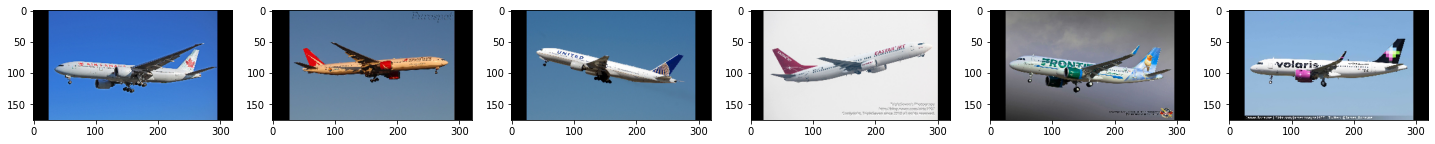

In [ ]:
n = 6
fig, ax = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(images_airplane)
  ax[i].imshow(img)
plt.show()

### Сегментированные изображения

In [ ]:
segments_airplane = []
cur_time = time.time()
for filename in sorted(os.listdir(directory_segment)):
  segments_airplane.append(image.load_img(os.path.join(directory_segment, filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - cur_time, 2)} cекунд')

Обучающая выборка завершина. Время загрузки: 37.6 cекунд


**Просмотр измененных сегментированных изображений**

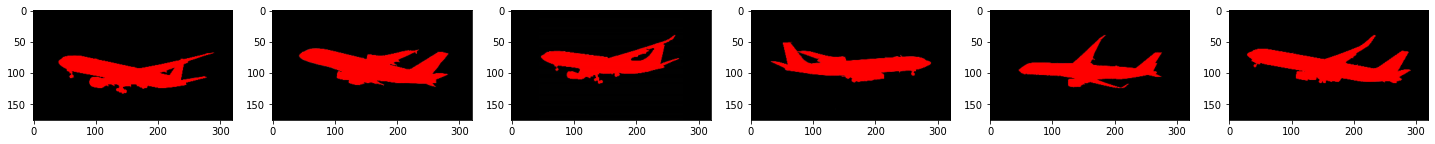

In [ ]:
n = 6
fig, ax = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(segments_airplane)
  ax[i].imshow(img)
plt.show()

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index = 0
  if (color[0] + color[1] + color[2] > 20):
    index = 1
  return index

In [ ]:
# Обратная функция из индекса в пиксель
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0]     # Черный
  elif index == 1:
    color = [255, 0 , 0]  # Красный
  return color

In [ ]:
# Обратная функция из индекса в пиксель
# def index2color(index2):
#   index = np.argmax(index2)
#   if index == 0:
#     return [0, 0, 0]   # Черный
#   return [255, 0 , 0]  # Красный

In [ ]:
# Функция перевода индекса пикслея в OHE
def rgbToOhe(y, num_classes):
  y_shape = y.shape                          # Запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3)  # (56320, 3)
  yt = []
  for i in range(len(y)):
    yt.append(to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим в OHE
  yt = np.array(yt)
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
  #print(yt.shape)
  return yt

In [ ]:
# Функция формирования yTrain
def y_pred(data, num_classes):
  yTrain = []
  for seg in data:
    y = image.img_to_array(seg)   # Переводим изображение в numpy-массив
    y = rgbToOhe(y, num_classes)  # Получаем OHE
    yTrain.append(y)
    #print(y.shape)
    if len(yTrain) % 100 == 0:
      print(len(yTrain))
  return np.array(yTrain)

## Создание xTrain и yTrain

## xTrain

In [ ]:
xTrain = []
for img in images_airplane:
  x = image.img_to_array(img) # Переводим изображение в numpy-массив
  xTrain.append(x)
xTrain = np.array(xTrain)
print(xTrain.shape)

(1000, 176, 320, 3)


## yTrain

In [ ]:
# cur_time = time.time()
# yTrain = y_pred(segments_airplane, num_classes)
# print (f'Время обработки: {round((time.time() - cur_time) / 60, 2)} минут')

100
200
300
400
500
600
700
800
900
1000
Время обработки: 11.31 минут


In [ ]:
yTrain.shape

(1000, 176, 320, 2)

In [ ]:
# Так как время создания выборки большое сохраним массивы на гугл диск

#np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/yTrain.npy', yTrain)
#np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/xTrain.npy', xTrain)

yTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/yTrain.npy')
xTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/xTrain.npy')

### Разделение на обучающую и тестовую выборки

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(900, 176, 320, 3)
(900, 176, 320, 2)
(100, 176, 320, 3)
(100, 176, 320, 2)


## Создание модели

In [ ]:
# Функция создания сети
def unet(num_classes=2, input_shape=(176,320,3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(64, (3,3), padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  x = MaxPooling2D()(block_1_out)

  # Block 2
  x = Conv2D(128, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)

  x = MaxPooling2D()(block_2_out)

  # Block 3
  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)

  x = MaxPooling2D()(block_3_out)

  # Block 4
  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)

  x = block_4_out


  # UP 2
  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)


  # UP 3
  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(128, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4
  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)

  model = Model(img_input,x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

**Собственная функция метрики, обрабатывающая пересечение двух областей**

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Обучение сети

In [ ]:
# Создание модели
modelAir = unet()  

### Просмотр модели

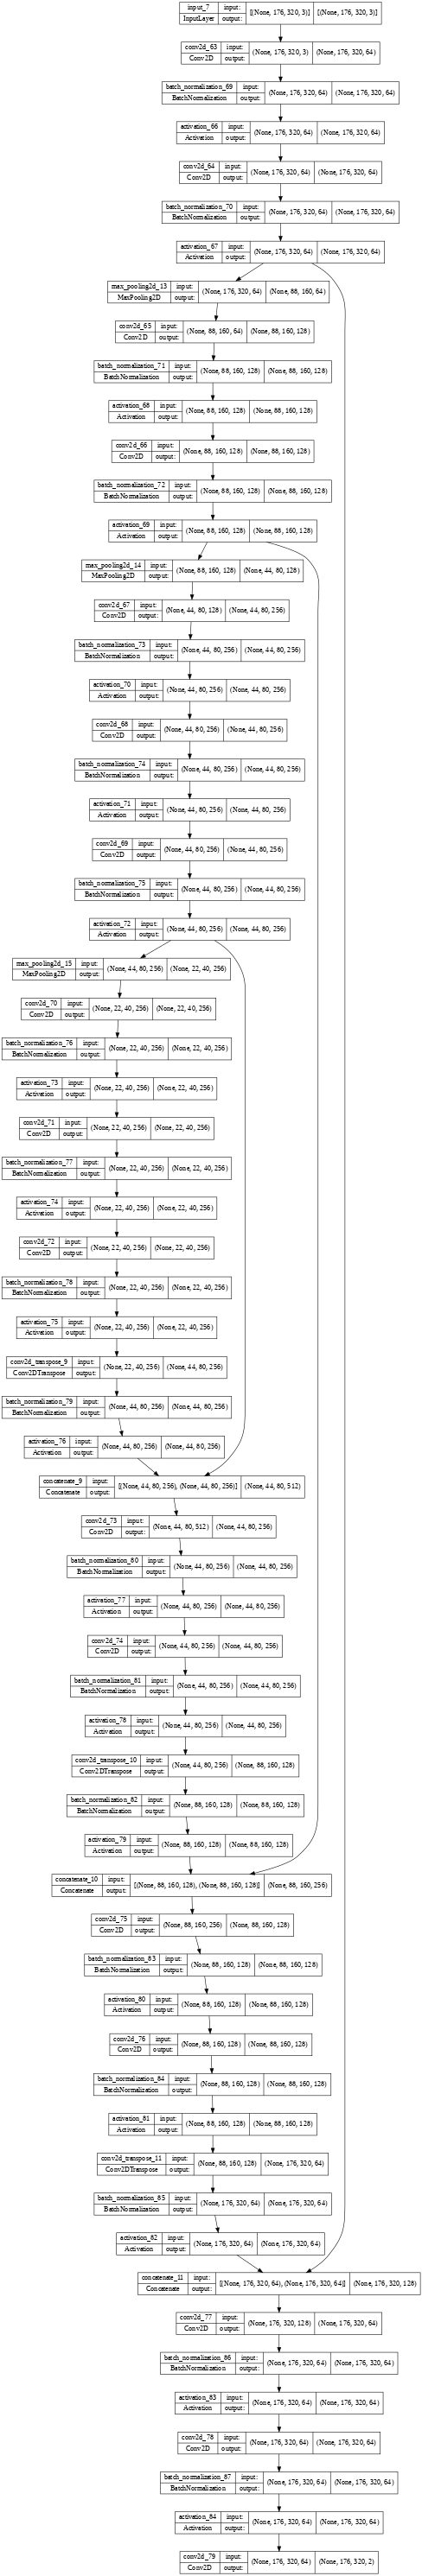

In [ ]:
plot_model(modelAir, show_shapes=True, dpi=40)

In [ ]:
modelAir.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 176, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 176, 320, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_69 (BatchN  (None, 176, 320, 64  256        ['conv2d_63[0][0]']              
 ormalization)                  )                                                           

### Обучение

In [ ]:
#history = modelAir.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val))
history = modelAir.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/35
57/57 [==============================] - 104s 1s/step - loss: 0.1749 - dice_coef: 0.8834 - val_loss: 0.3674 - val_dice_coef: 0.7210
Epoch 2/35
57/57 [==============================] - 74s 1s/step - loss: 0.0687 - dice_coef: 0.9568 - val_loss: 0.3245 - val_dice_coef: 0.8224
Epoch 3/35
57/57 [==============================] - 74s 1s/step - loss: 0.0518 - dice_coef: 0.9689 - val_loss: 0.3556 - val_dice_coef: 0.8592
Epoch 4/35
57/57 [==============================] - 74s 1s/step - loss: 0.0487 - dice_coef: 0.9723 - val_loss: 0.2475 - val_dice_coef: 0.9001
Epoch 5/35
57/57 [==============================] - 74s 1s/step - loss: 0.0414 - dice_coef: 0.9772 - val_loss: 0.1770 - val_dice_coef: 0.9276
Epoch 6/35
57/57 [==============================] - 74s 1s/step - loss: 0.0371 - dice_coef: 0.9798 - val_loss: 0.1143 - val_dice_coef: 0.9452
Epoch 7/35
57/57 [==============================] - 74s 1s/step - loss: 0.0358 - dice_coef: 0.9806 - val_loss: 0.0461 - val_dice_coef: 0.9779
Epoch

In [ ]:
# Посмотрим лучших результат
max(history.history['val_dice_coef']) * 100

98.80663752555847

In [ ]:
# Сохраним полученные веса
modelAir.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/modelAir.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
modelAir = unet()
modelAir.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Самолетов/modelAir.h5')

[62 93 41  5 77 26]


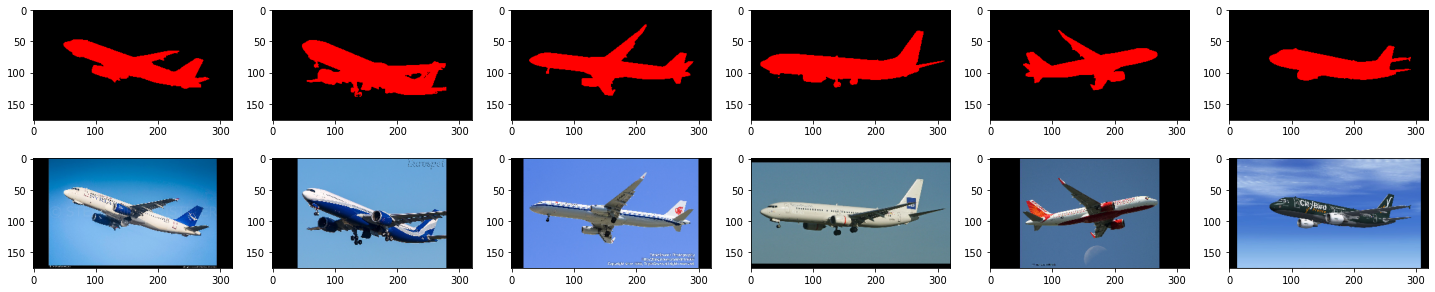

In [ ]:
count = 6
num_classes = 2 
indexes = np.random.randint(0, len(x_val), count)   # Получаем count случайных индексов
print(indexes)
fig, axs = plt.subplots(2, count, figsize=(25,5))
for i, idx in enumerate(indexes):
  predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3)))   # (1, 176, 320, 2)
  pr = predict[0]
  pr = pr.reshape(-1, num_classes)      # (56320, 2)
  pr1 = []                                 # Пустой лист под сегментированную картинку из predicta
  
  for k in range(len(pr)):
    pr1.append(index2color(pr[k]))
  
  pr1 = np.array(pr1)
  pr1 = pr1.reshape(img_width, img_height, 3)
  img = Image.fromarray(pr1.astype('uint8'))
  axs[0,i].imshow(img.convert('RGBA'))
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))
  
plt.show()

## Наложение маски

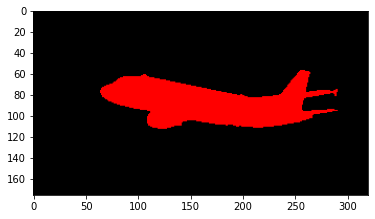

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)
plt.show()

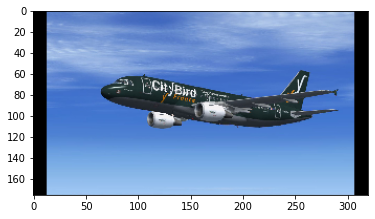

In [ ]:
img_air = Image.fromarray(x_val[idx].astype('uint8'))
plt.imshow(img_air)
plt.show()

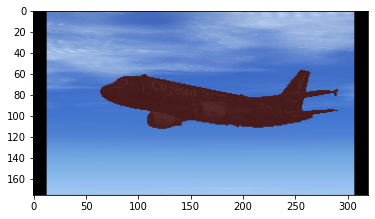

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [100, 0, 0, 150]
img = Image.fromarray(mask).convert('RGBA')

img_air.paste(img, (0, 0),img)
plt.imshow(img_air)
plt.show()

# Сегментация стройки
**Дополнительное задание**

### Задание глобальных параметров

In [ ]:
img_width  = 176     # Ширина
img_height = 240     # Высота
directory       = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/'  
train_directory = 'Тренировочная_стройка/'
val_directory   = 'Проверочная_стройка/'
num_classes = 7     # Количество классов

## Загрузка изображений



### Оригинальные изображения

In [ ]:
train_images = []  # Список обучающей выборки
val_images = []    # Список проверочной выборки

curr_time = time.time()
for filename in sorted(os.listdir(directory + train_directory + 'Исходники')):
  train_images.append(image.load_img(os.path.join(directory + train_directory + 'Исходники', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(train_images))

curr_time = time.time()
for filename in sorted(os.listdir(directory + val_directory + 'Исходники')):
  val_images.append(image.load_img(os.path.join(directory + val_directory + 'Исходники', filename), target_size=(img_width, img_height)))
print (f'Проверочная выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(val_images))

Обучающая выборка завершина. Время загрузки: 29.04 cекунд
Количество изображений:  900
Проверочная выборка завершина. Время загрузки: 19.49 cекунд
Количество изображений:  50


### Проверка полученных изображений

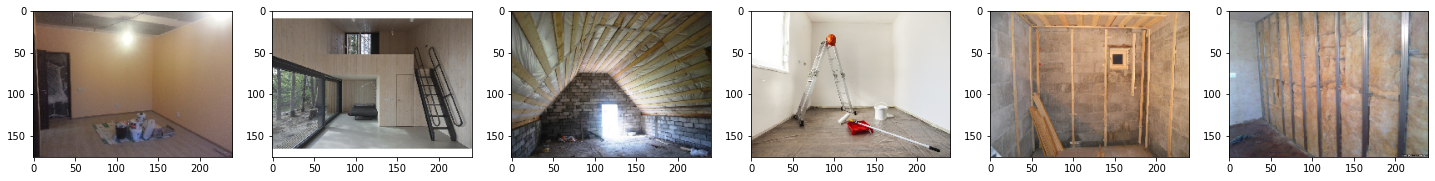

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img)
plt.show()

### Сегментированные изображения

In [ ]:
train_segments = []
val_segments = []

curr_time = time.time()
for filename in sorted(os.listdir(directory + train_directory + 'Размеченные')):
  train_segments.append(image.load_img(os.path.join(directory + train_directory + 'Размеченные', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(train_segments))

curr_time = time.time()
for filename in sorted(os.listdir(directory + val_directory + 'Размеченные')):
  val_segments.append(image.load_img(os.path.join(directory + val_directory + 'Размеченные', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(val_segments))

Обучающая выборка завершина. Время загрузки: 36.19 cекунд
Количество изображений:  900
Обучающая выборка завершина. Время загрузки: 20.62 cекунд
Количество изображений:  50


### Проверка полученных **сегментированных** изображений

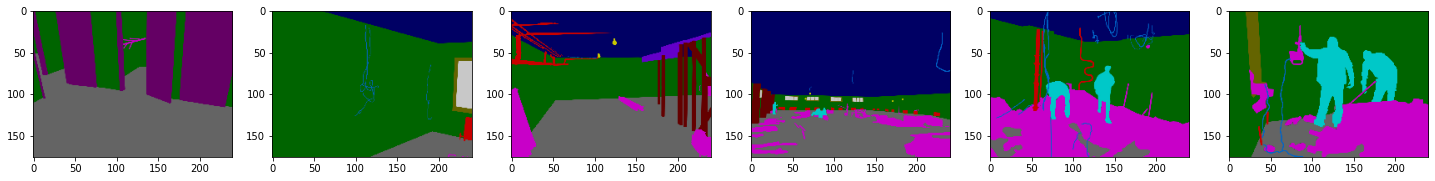

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_segments)
  axs[i].imshow(img)
plt.show()

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
    index=-1
    if   (149>=color[0]>51)   and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=0 # пол

    elif (49>=color[0]>=0)    and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=1 # потолок

    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=2 # стена
  
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=3 # проем
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=3 # дверь
    elif (149>=color[0]>=51)  and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=3 # окно

    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=4 # колонна
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (249>=color[2]>=151) : index=4 # внешний мир
    elif (49>=color[0]>=0)    and (49>=color[1]>=51)   and (249>=color[2]>=151) : index=4 # лестница
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # перила
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=4 # батарея
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # инвентарь
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # источники света
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (249>=color[2]>=151) : index=4 # провода
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # балка

    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (249>=color[2]>=151) : index=5 # люди

    else: index=6

    return index  

In [ ]:
# Из индекса в цвет
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:   color = [100, 100, 100]   # Пол                  -  СЕРЫЙ 
  elif index == 1: color = [0, 0, 100]       # Потолок              -  СИНИЙ
  elif index == 2: color = [0, 100, 0]       # Стена                -  ЗЕЛЕНЫЙ
  elif index == 3: color = [100, 0, 0]       # Проем, дверь, окно   -  КРАСНЫЙ
  elif index == 4: color = [0, 100, 100]     # Колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка - ГОЛУБОЙ
  elif index == 5: color = [100, 0, 100]     # Люди                 -  РОЗОВЫЙ
  elif index == 6: color = [0, 0, 0]         # Остальное            -  ЧЕРНЫЙ
  return color

In [ ]:
# Функция перевода индекса пикслея в OHE
def rgbToOhe(y, num_classes):
  y_shape = y.shape                          # Запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3)  # (56320, 3)
  yt = []
  for i in range(len(y)):
    yt.append(to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим в OHE
  yt = np.array(yt)
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
  return yt

In [ ]:
# Функция формирования yTrain
def y_pred(data, num_classes):
  yTrain = []
  for seg in data:
    y = image.img_to_array(seg)   # Переводим изображение в numpy-массив
    y = rgbToOhe(y, num_classes)  # Получаем OHE
    yTrain.append(y)
    if len(yTrain) % 100 == 0:
      print(len(yTrain))
  return np.array(yTrain)

## Создание xTrain и yTrain

## xTrain, xVal

In [ ]:
xTrain = []
for img in train_images:
  x = image.img_to_array(img)
  xTrain.append(x)
xTrain = np.array(xTrain)

xVal = []
for img in val_images:
  x = image.img_to_array(img)
  xVal.append(x)
xVal = np.array(xVal)

print('xTrain: ', xTrain.shape)
print('xVal:   ', xVal.shape)

xTrain:  (900, 176, 240, 3)
xVal:    (50, 176, 240, 3)


## yTrain, yVal

In [ ]:
curr_time = time.time()
yTrain = y_pred(train_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

100
200
300
400
500
600
700
800
900
Время обработки: 29.59 минут


In [ ]:
curr_time = time.time()
yVal = y_pred(val_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

Время обработки: 1.57 минут


In [ ]:
print('xTrain: ', xTrain.shape)
print('yTrain: ', yTrain.shape)

print('xVal:   ', xVal.shape)
print('yVal:   ', yVal.shape)

xTrain:  (900, 176, 240, 3)
yTrain:  (900, 176, 240, 7)
xVal:    (50, 176, 240, 3)
yVal:    (50, 176, 240, 7)


## Сохранение и загрузка массивов  

In [ ]:
# Так как время создания выборки большое сохраним массивы на гугл диск
# # Сохранение
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/xTrain.npy', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/yTrain.npy', yTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/xVal.npy', xVal)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/yVal.npy', yVal)

# Загрузка
xTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/xTrain.npy')
yTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/yTrain.npy')
xVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/xVal.npy')
yVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/yVal.npy')

## Создание модели и дополнительные функции

### U-net

In [ ]:
def unet(num_classes=7, input_shape=(176,240,3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(64, (3,3), padding='same')(img_input)  # (176,240,3)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)          # (176,240,64)   
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)               # (176,240,64)  

  x = MaxPooling2D()(block_1_out)                   # (88,120,64)

  # Block 2
  x = Conv2D(128, (3,3), padding='same')(x)         # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)         # (88,120,128)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)               # (88,120,128)

  x = MaxPooling2D()(block_2_out)                   # (44,60,128)

  # Block 3
  x = Conv2D(256, (3,3), padding='same')(x)         # (44,60,256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)         # (44,60,256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)         # (44,60,256)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)               # (44,60,256)

  x = MaxPooling2D()(block_3_out)                   # (22,30,256)

  # Block 4
  x = Conv2D(512, (3,3), padding='same')(x)         # (22,30,512)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512, (3,3), padding='same')(x)         # (22,30,512)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512, (3,3), padding='same')(x)         # (22,30,512)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  x = block_4_out
   

  # UP 2
  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(x)   # (44,60,256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])             # (44,60,256) и # (44,60,256)
  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)     # (44,60,256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3
  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)   # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])      
  x = Conv2D(128, (3,3), padding='same')(x)     # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)    # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4
  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x) # (176,240,64) 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)      # (176,240,64) 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)  # (176,240,7) 

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Собственная функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count=6, n_classes=7):
  indexes = np.random.randint(0, len(xVal), count)
  
  fig, axs = plt.subplots(3, count, figsize=(25,7))
  for i, idx in enumerate(indexes):
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3)))
    pr = predict[0]
    pr1 = []                                # Сегментированная картинка из predicta
    yr2 = []                                # Сегменитрованная картинка из yVal
    pr = pr.reshape(-1, n_classes)          # Решейп предикта
    yr = yVal[idx].reshape(-1, n_classes)   # Решейп yVal
    for k in range(len(pr)):
      pr1.append(index2color(pr[k]))
      yr2.append(index2color(yr[k]))
    
    pr1 = np.array(pr1)
    pr1 = pr1.reshape(img_width, img_height, 3)
    yr2 = np.array(yr2)
    yr2 = yr2.reshape(img_width, img_height, 3)

    img = Image.fromarray(pr1.astype('uint8'))

    axs[0,i].imshow(img.convert('RGBA'))
    axs[1,i].imshow(Image.fromarray(yr2.astype('uint8')))
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8')))
  plt.show()

## Создание и обучение сети

In [ ]:
model = unet()
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data=(xVal, yVal))

Epoch 1/50
29/29 [==============================] - 101s 3s/step - loss: 1.5447 - dice_coef: 0.2947 - val_loss: 1.9207 - val_dice_coef: 0.1747
Epoch 2/50
29/29 [==============================] - 64s 2s/step - loss: 1.0738 - dice_coef: 0.4729 - val_loss: 1.6011 - val_dice_coef: 0.2427
Epoch 3/50
29/29 [==============================] - 64s 2s/step - loss: 0.9321 - dice_coef: 0.5314 - val_loss: 1.5657 - val_dice_coef: 0.2944
Epoch 4/50
29/29 [==============================] - 64s 2s/step - loss: 0.8421 - dice_coef: 0.5740 - val_loss: 1.4600 - val_dice_coef: 0.3171
Epoch 5/50
29/29 [==============================] - 64s 2s/step - loss: 0.7919 - dice_coef: 0.5971 - val_loss: 1.3898 - val_dice_coef: 0.3612
Epoch 6/50
29/29 [==============================] - 64s 2s/step - loss: 0.7366 - dice_coef: 0.6253 - val_loss: 1.3492 - val_dice_coef: 0.3951
Epoch 7/50
29/29 [==============================] - 64s 2s/step - loss: 0.7103 - dice_coef: 0.6392 - val_loss: 1.1690 - val_dice_coef: 0.4678
Epoch

## Дообучение сети

In [ ]:
history = model.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data=(xVal, yVal))

Epoch 1/50
57/57 [==============================] - 69s 1s/step - loss: 0.5669 - dice_coef: 0.7393 - val_loss: 1.1659 - val_dice_coef: 0.6397
Epoch 2/50
57/57 [==============================] - 58s 1s/step - loss: 0.3483 - dice_coef: 0.8135 - val_loss: 1.2648 - val_dice_coef: 0.6121
Epoch 3/50
57/57 [==============================] - 58s 1s/step - loss: 0.2543 - dice_coef: 0.8619 - val_loss: 1.1605 - val_dice_coef: 0.6787
Epoch 4/50
57/57 [==============================] - 58s 1s/step - loss: 0.2451 - dice_coef: 0.8708 - val_loss: 1.1902 - val_dice_coef: 0.6803
Epoch 5/50
57/57 [==============================] - 58s 1s/step - loss: 0.2169 - dice_coef: 0.8835 - val_loss: 1.1466 - val_dice_coef: 0.6924
Epoch 6/50
57/57 [==============================] - 58s 1s/step - loss: 0.2060 - dice_coef: 0.8901 - val_loss: 1.3409 - val_dice_coef: 0.6506
Epoch 7/50
57/57 [==============================] - 58s 1s/step - loss: 0.1851 - dice_coef: 0.9008 - val_loss: 1.5245 - val_dice_coef: 0.6370
Epoch 

In [ ]:
print(f"Лучший результат при обучении: {max(history.history['val_dice_coef']) * 100}")

Лучший результат при обучении: 72.24040031433105


### Сохранение весов модели

In [ ]:
model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/model.h5')

## Распознавание изображений

In [ ]:
# Загрузка модели
model = unet()
model.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/model.h5')

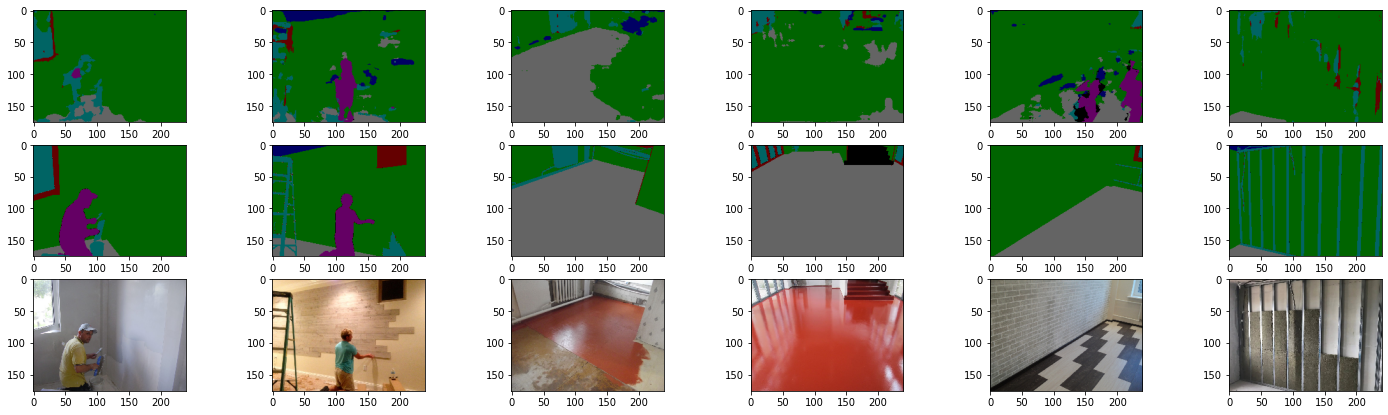

In [ ]:
processImage(model)

# Выводы:

1. Весь код писался в ручную для лучшего понимания
2. Так же дополнительно было сделано задание по сегментации изображения со стройки.
3. Подготовка данных важный момент в решение задач секментации.
4. Для лучшего результата требуется большая база размеченных изображений для каждого класса.
5. Чем меньше классов тем лучше справляется нейронная сеть.
6. Бинарная сегментация на примере самолетов показала лучший результат.
7. Так же необходимо для каждой задачи подбирать наиболее подходящую архитектуру нейронной сети.